<a href="https://colab.research.google.com/github/shariq101/NLP-Shakespearean_word_Gen/blob/main/Shakespeare_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import string
import gensim
import time
import itertools
import pickle
from torch.utils.data import DataLoader
from torch import nn
from sklearn.model_selection import KFold
import pandas as pd
import csv
from scipy.special import softmax
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(614)

In [99]:
# GPU
usingCuda = False
if torch.cuda.is_available():
    usingCuda = True
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
print('Using Cuda:', usingCuda)

Using Cuda: True


In [8]:
from google.colab import files
uploaded = files.upload()

Saving HAMLET.txt to HAMLET.txt


In [9]:
titles = ["HAMLET.txt", "SONNET.txt", "MACBETH.txt", "ROMEO_ AND_JULIET.txt", "THE_TEMPEST.txt"]

In [35]:
usingColab=True
if usingColab:
    from google.colab import files
    path = '/content/'
else:
    path = ''

In [36]:
def preprocess(input, load, filename='/shakes.txt', is_seed=False):

    if load:

        shakes = open(path+filename, 'r').read()
        print("Opened "+ str(filename))
        alphabet = list(set(shakes))
        alphabet.sort()
        print('Found letters:', alphabet)
        return shakes

    else:

        if is_seed:
            shakes = input
        else:
            titles = input
            #building one single text
            texts_list=[open(path+text, 'r').read() for text in titles]
            shakes = ""
            for text in texts_list:
                shakes+=text

        #removing chapter headers
        shakes = re.sub(r'CHAPTER.*\n+', '\n\n', shakes)
        shakes = re.sub(r'Chapter.*\n+', '\n\n', shakes)

        #lowercase
        shakes = shakes.lower()

        #remove newlines inside text (no "true" newlines)
        shakes = re.sub('(?<=[^.])\n'," ",shakes)
        
        #sobstituting these characters with spaces
        odd_characters = ['"', '&', "'", '(', ')', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']', '_', '£', '—', '‘', '’', '“', '”']
        rx = '[' + re.escape(''.join(odd_characters)) + ']'
        shakes = re.sub(rx, ' ', shakes)

        #sobstituting some punctuation with "."
        punct_to_point = ['!', ':', ';']
        rx = '[' + re.escape(''.join(punct_to_point)) + ']'
        shakes = re.sub(rx, '.', shakes)

        #sobstituting accented vowels with "normal" version
        accented = ['à', 'é', 'ê']
        not_accented = ['a', 'e', 'e']
        for a, na in zip(accented, not_accented):
            shakes = re.sub(a, na, shakes)

        #sobstituting residual punctuation with words
        shakes = re.sub('['+','+']', ' '+'commapunct'+' ', shakes)
        shakes = re.sub('['+'.'+']', ' '+'fullstoppunct'+' ', shakes)
        shakes = re.sub('['+'?'+']', ' '+'questpunct'+' ', shakes)

        #remove multiple spaces
        shakes = re.sub(' +', ' ', shakes)

        alphabet = list(set(shakes))
        alphabet.sort()
        print('Found letters:', alphabet)

        import codecs
        with codecs.open(path+filename, 'w', encoding="UTF-8") as F:
           F.write(shakes)

        return shakes

In [84]:
class MyDataset():
    def __init__(self, text, emb_dim=100, threshold=20, load=True):

        self.text = text
        self.sentences = self.get_sentences(threshold)
        self.embedding_w2v(emb_dim, load)

    def __len__(self):
          return len(self.sentences)

    def get_sentences(self, threshold):

        #Splitting in paragraphs. They alla end with a full stop and a newline. The output is a list of paragraphs
        paragraphs = re.split('fullstoppunct'+ ' ' + '\n', self.text)
        #Splitting each paragraph in its words
        paragraphs = [x.split() for x in paragraphs]
        #Paragraph is kept only if it is composed by more than "threshold" words! 
        # a quel punto per forza considero anche al punteggiatura
        paragraphs = [x for x in paragraphs if len(x) >= threshold]
        #the we separate each paragraph is as many sub-phrases as possible
        sentences=[]
        for par in paragraphs:
            start = 0
            end = start + threshold
            while end <= len(par):
                sentences.append(par[start:end])
                start +=threshold
                end +=threshold
        return sentences

    def embedding_w2v(self, emb_dim, load):

        if load:

            self.w2i = pickle.load(open(path+"embedding_model/w2i.p", "rb"))  
            self.i2w = pickle.load(open(path+"embedding_model/i2w.p", "rb"))
            self.w2s = pickle.load(open(path+"embedding_model/w2s.p", "rb")) 

        else:

            start=time.time()
            embedding_model = gensim.models.Word2Vec(self.sentences, size=emb_dim, min_count=1, window=5, workers=4, iter=200)
            end=time.time()
            #saving model so tat it can be used again (see later for visualization)
            embedding_model.save(path+'embedding_model.bin')
            print("Elapsed time for word embedding:", end-start)

            words = list(embedding_model.wv.vocab)
            self.w2i = {w: i for i, w in enumerate(embedding_model.wv.index2word)}      
            self.i2w = {embedding_model.wv.vocab[w].index : w for w in words}           
            
            #word 2 self to decode correctly punctuation
            self.w2s = {w : w for w in words}
            self.w2s['fullstoppunct'] = '.'
            self.w2s['commapunct'] = ','
            self.w2s['questpunct'] = '?'
            
            #saving embedding 
            torch.save(torch.FloatTensor(embedding_model.wv.vectors), f = path+"embedding.torch")
            #saving w2i and i2w
            pickle.dump(self.w2i, open(path+"w2i.p", "wb"))  
            pickle.dump(self.i2w, open(path+"i2w.p", "wb"))  
            pickle.dump(self.w2s, open(path+"w2s.p", "wb")) 

        
    def __getitem__(self, idx):
           text = self.sentences[idx]
           #encode
           encoded = encode(self.w2i,text)
           #sample contains both the sentence and its encoded version
           sample = {'text': text, 'encoded': encoded}
           return sample


def encode(dict_w2i, text):
    encoded = [dict_w2i[word] for word in text]
    return torch.LongTensor(encoded)

def decode(dict_i2w, numeric_text):
    decoded = [dict_i2w[num] for num in numeric_text]
    return decoded          

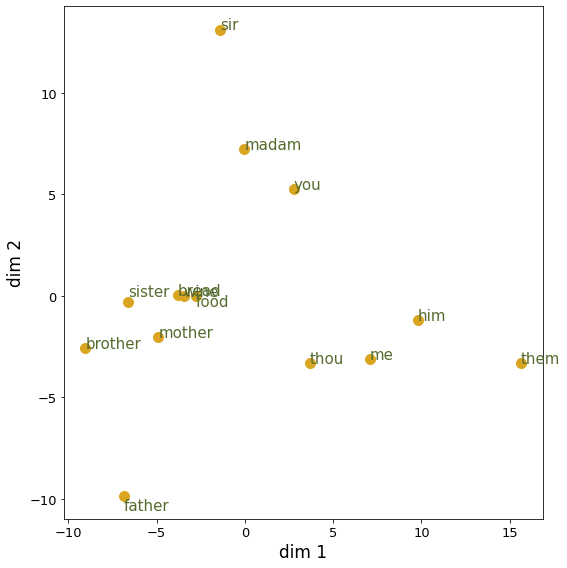

In [68]:
from sklearn.decomposition import PCA
emb_model = gensim.models.Word2Vec.load(path+"embedding_model.bin")
words=["mother", "father", "sister", "brother", "bread", "food", "thou", "wine",  "me", "you", "him", "them","sir","madam"]#,"tomorrow", "today", "yesterday",]
embedded = emb_model[words]
reduced = PCA(n_components = 2).fit_transform(embedded)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(reduced[:,0], reduced[:,1], color="goldenrod", s=100)
for i,word in enumerate(words):
    if word == "sister":
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]+0.3), color="darkolivegreen", fontsize=15)
    elif word == "food":
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]-0.5), color="darkolivegreen", fontsize=15)
    elif word == "father":
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]-0.7), color="darkolivegreen", fontsize=15)
    else:
        ax.annotate(word, xy=(reduced[i,0], reduced[i,1]), color="darkolivegreen", fontsize=15)    
ax.set_ylabel("dim 2", fontsize=17)
ax.set_xlabel("dim 1", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
fig.tight_layout()
fig.savefig(path+"/embedding_ex.png")

In [89]:
load_embedding = True
load_preprocessed = True
shakes = preprocess(titles, False)
shakesDataset = MyDataset(shakes, 100, 25, False)
print("\n\nINFORMATION ON THIS DATASET")
print("\n")
print("Number of sentences:", len(shakesDataset.sentences))
print("Number of unique words:", len(shakesDataset.w2i))
print("\n")
#print("Number of unique words:", len(shakesDataset))
#print("\n")
#each train or test entry is a dictionary as in __getitem__
g =torch.cuda.manual_seed(614)
train, test = torch.utils.data.random_split(shakesDataset, [int(len(shakesDataset)*0.8),len(shakesDataset)-int(len(shakesDataset)*0.8)], generator=g)
print('Size of training set:',len(train))
print('Size of test set:',len(test))

Found letters: ['\n', ' ', '#', '$', '%', '*', '+', '/', '<', '=', '>', '@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', 'á', 'æ', 'ó', 'ý', 'œ', '„', '\ufeff']
Elapsed time for word embedding: 21.666335344314575


INFORMATION ON THIS DATASET


Number of sentences: 4468
Number of unique words: 9713


Size of training set: 3574
Size of test set: 894


In [91]:
class Network(nn.Module):
    def __init__(self, len_vocab, emb_dim, hidden_units, layers, dropout):
        super().__init__()

        #Creating pre-trained embedding layer at the beginning using the weight already computed
        embedding_matrix= torch.load(path+"embedding.torch")
        embedding_matrix = torch.FloatTensor(embedding_matrix)
        self.embedding = nn.Embedding(len_vocab, emb_dim).from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad=False   #pretrained

        self.rnn = nn.LSTM(input_size=emb_dim, 
                           hidden_size=hidden_units,
                           num_layers=layers,
                           dropout=dropout, 
                           batch_first=True)
        # Define output layer
        self.out = nn.Linear(hidden_units, len_vocab)
        
    def forward(self, x, state=None):
        #Embedding
        x = self.embedding(x)
        # LSTM
        x, rnn_state = self.rnn(x, state)
        # Linear layer
        x = F.leaky_relu(self.out(x))

        return x, rnn_state

    
    def train_epoch(self, dataloader, loss_fn, optimizer):
        # Training
        self.train()
        train_loss = []
        for batch_sample in dataloader:
            sample_batch = batch_sample['encoded']
            x = sample_batch[:, :-1].to(device) #all words besides the last
            y = sample_batch[:, 1:].to(device)  #all words besides the first one
            optimizer.zero_grad()
            predicted, _ = self.forward(x) #predicted has size (batchsize, 24, len_vocab)
            loss = loss_fn(predicted.transpose(1, 2), y) #transpose so that predicted and y match
            loss.backward()
            optimizer.step()
            train_loss.append(loss.data.cpu().numpy())
        return np.mean(np.array(train_loss))



    def test_epoch(self, test_dataloader, loss_fn):
        # Validation
        self.eval() # Evaluation mode (e.g. disable dropout)
        test_loss = []
        with torch.no_grad(): # No need to track the gradients
            for batch_sample in test_dataloader:
                sample_batch = batch_sample['encoded']
                x = sample_batch[:, :-1].to(device) #all words besides the last
                y = sample_batch[:, 1:].to(device)  #all words besides the first one
                predicted, _ = self.forward(x) #predicted has size (batchsize, 24, len_vocab)
                loss = loss_fn(predicted.transpose(1, 2), y) 
                test_loss.append(loss.data.cpu().numpy())
        return np.mean(np.array(test_loss))


    def train_full(self, epochs, patience, train_dataloader, val_dataloader, loss_fn, optimizer, verbose, filename):

        val_loss_best = float(1000)
        train_loss_log=[]
        val_loss_log=[]
        for epoch in range(epochs):

            start = time.time()

            train_loss = self.train_epoch(train_dataloader, loss_fn=loss_fn, optimizer=optim) 
            val_loss = self.test_epoch(val_dataloader, loss_fn=loss_fn) 

            end = time.time()

            #Print Validation loss

            if verbose:
                print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, epochs, val_loss))
                print("\n Time elapsed for one epoch:", end-start)

            if val_loss <= val_loss_best:
                # Save network parameters
                torch.save(self, path+filename)
                val_loss_best = val_loss
                waiting = 0
            else:
                waiting +=1

            #Early stopping
            if waiting >= patience and epoch > 20:
                return train_loss_log, val_loss_log
                print("Val loss has not improved for %d epochs ---> early stopping" %(patience))
                print("Best validation error was at epoch %d " %(epoch - patience))
                break

            train_loss_log.append(train_loss)
            val_loss_log.append(val_loss)
            torch.cuda.empty_cache()
            
        return train_loss_log, val_loss_log


    def predict(self, seed_text, text_length):

        clean_seed_text = preprocess(seed_text, load=False, filename="temp.txt", is_seed=True)
        clean_seed_text = clean_seed_text.split()
        w2i = pickle.load(open(path+"w2i.p", "rb"))  
        i2w = pickle.load(open(path+"i2w.p", "rb")) 
        w2s = pickle.load(open(path+"w2s.p", "rb"))
        encoded = encode(w2i, clean_seed_text)
        encoded = encoded.unsqueeze(0).to(device)
        print(seed_text, end='', flush=True)

        #Creating context (needed to create first hidden state)
        self.eval() 
        with torch.no_grad():
            out, hstate = self(encoded)
            next = self.softmax_sampling(out[:, -1, :].cpu().numpy())
            decoded = i2w[next]
            print(w2s[decoded], end=' ', flush=True)
            encoded = torch.LongTensor([next])
            encoded = encoded.unsqueeze(0).to(device)
        for words in range(text_length-1):
            with torch.no_grad():
                out, hstate = self(encoded, hstate)
                next = self.softmax_sampling(out[:, -1, :].cpu().numpy())
                decoded = i2w[next]
                print(w2s[decoded], end=' ', flush=True)
                encoded = torch.LongTensor([next])
                encoded = encoded.unsqueeze(0).to(device)


    def softmax_sampling(self,x,return_prob=False):
        prob = softmax(x)
        vocab_idx = np.arange(prob.shape[1])
        prob = prob.reshape(-1,) #remove batch dim
        next_word = np.random.choice(vocab_idx, p=prob)
        if return_prob:
            return next_word.item(), prob
        return next_word.item()
              

In [100]:
training = True
verbose = True

if training:

    #--------MODELS-----------------#
    pars = {"hidden_units" : [32, 64, 128, 256], "layers" : [2,3], "optimizer" : ['torch.optim.Adamax',"torch.optim.Adam"]}
    models = [dict(zip(pars.keys(), a)) for a in itertools.product(*pars.values())]

    #--------FIXED PARAMETERS-------#
    n_folds = 3
    patience = 10
    num_epochs = 120
    dropout = 0.3
    len_vocab = len(shakesDataset.i2w)
    emb_dim=100
    loss_fn = nn.CrossEntropyLoss()

    filename = path+"Models2.csv"
    parameters=["hidden_units", "layers", "optimizer", "val_loss"]
    list_of_models = pd.DataFrame(columns=parameters)
    list_of_models.to_csv(filename,index=False)

    # Split and train
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train)

    for nm, model in enumerate(models[10:]):

        print("\n\nTraining model:", nm)

        with open(filename,'a',newline='') as f:
            writer=csv.writer(f)

            #loop over folds
            CVlosses=[]
            cv_loop = 0

            for train_index, val_index in kfolds.split(train):

                print("\n\n\tTraining fold:", cv_loop)

                #reinitialize the network
                net = Network(len_vocab = len(shakesDataset.i2w), emb_dim=100, hidden_units=model["hidden_units"], layers=model["layers"], dropout=0.3)
                optim = eval(model["optimizer"])(filter(lambda p: p.requires_grad, net.parameters()),lr=1e-3, weight_decay=5e-4)
                net.to(device)

                ###divide validation and training set
                train_set = torch.utils.data.Subset(train, train_index)
                val_set = torch.utils.data.Subset(train, val_index)
                ### Define dataloader
                train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True, generator=torch.Generator(device='cuda'))
                val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False, generator=torch.Generator(device='cuda'))

                #Train for #epochs with early stopping
                tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn=loss_fn, 
                                        optimizer=optim, verbose=verbose, filename="temp.torch")
                #load best model
                net = torch.load(path+"temp.torch")
                #compute validation loss over best model
                val_loss = net.test_epoch(val_dataloader, loss_fn)

                cv_loop +=1

                CVlosses.append(val_loss)

            #avg val loss for model
            CVloss = np.array(CVlosses).mean()
            model_dict={**model, "val_loss":CVloss}
            writer.writerow(list(model_dict.values()))
            f.close()  

else:

    print("Training flag is set to FALSE so no training was performed")

Streaming output truncated to the last 5000 lines.
	 VALIDATION - EPOCH 9/120 - loss: 6.585672



 Time elapsed for one epoch: 0.8015537261962891


	 VALIDATION - EPOCH 10/120 - loss: 6.545701



 Time elapsed for one epoch: 0.803687334060669


	 VALIDATION - EPOCH 11/120 - loss: 6.524948



 Time elapsed for one epoch: 0.8038675785064697


	 VALIDATION - EPOCH 12/120 - loss: 6.511508



 Time elapsed for one epoch: 0.8008906841278076


	 VALIDATION - EPOCH 13/120 - loss: 6.499388



 Time elapsed for one epoch: 0.8015775680541992


	 VALIDATION - EPOCH 14/120 - loss: 6.489712



 Time elapsed for one epoch: 0.8036978244781494


	 VALIDATION - EPOCH 15/120 - loss: 6.483608



 Time elapsed for one epoch: 0.8143181800842285


	 VALIDATION - EPOCH 16/120 - loss: 6.479229



 Time elapsed for one epoch: 0.8013110160827637


	 VALIDATION - EPOCH 17/120 - loss: 6.475945



 Time elapsed for one epoch: 0.8075885772705078


	 VALIDATION - EPOCH 18/120 - loss: 6.473017



 Time elapsed for one

In [102]:
filename=path+"Models2.csv"
models = pd.read_csv(filename, sep=",").sort_values("val_loss")
pd.set_option('display.expand_frame_repr', False)
print(models)
best_set = models.iloc[[models.val_loss.argmin()]]
print("\n\nSet of best performing hyperparameters:")
print(best_set)
#save best set
best_set.to_csv(path+"best_set.csv", index=False)

   hidden_units  layers           optimizer  val_loss
3           256       2    torch.optim.Adam  5.499170
5           256       3    torch.optim.Adam  5.578047
1           128       3    torch.optim.Adam  5.884891
2           256       2  torch.optim.Adamax  6.145901
4           256       3  torch.optim.Adamax  6.153162
0           128       3  torch.optim.Adamax  6.396683


Set of best performing hyperparameters:
   hidden_units  layers         optimizer  val_loss
3           256       2  torch.optim.Adam   5.49917


In [117]:
final_train = True
verbose = True

if final_train:

    #Load best hyperparameters
    best_set=pd.read_csv(path+"best_set.csv", sep=",")
    best_set=best_set.drop(["val_loss"], axis=1).to_dict("r")[0]
    hidden_units = best_set["hidden_units"]
    optimizer = best_set["optimizer"]
    layers=best_set["layers"]
    
    #Rest of parameters
    n_folds = 3
    patience = 12
    num_epochs = 200
    dropout = 0.3
    len_vocab = len(shakesDataset.i2w)
    emb_dim=100
    loss_fn = nn.CrossEntropyLoss()

    
    #no cross validation is performed but a validation set is used for early stopping
    kfolds = KFold(n_splits=n_folds,random_state=0, shuffle=True)
    kfolds.get_n_splits(train)
    
        
    for train_index, val_index in kfolds.split(train):

        #reinitialize the network
        net = Network(len_vocab = len(shakesDataset.i2w), emb_dim=emb_dim, hidden_units=best_set["hidden_units"], layers=best_set["layers"], dropout=0.3)
        optim = eval(best_set["optimizer"])(filter(lambda p: p.requires_grad, net.parameters()),lr=1e-3, weight_decay=5e-4)
        net.to(device)

        ###divide validation and training set
        train_set = torch.utils.data.Subset(train, train_index)
        val_set = torch.utils.data.Subset(train, val_index)
        ### Define dataloader
        train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True, generator=torch.Generator(device='cuda'))
        val_dataloader = DataLoader(val_set, batch_size=512, shuffle=False, generator=torch.Generator(device='cuda'))

        #Train for #epochs with early stopping
        tl, vl = net.train_full(num_epochs, patience, train_dataloader, val_dataloader, loss_fn=loss_fn, 
                                optimizer=optim, verbose=verbose, filename="Final_model.torch")
        #load best model
        device = torch.device("cuda")
        net = torch.load(path+"Final_model.torch").cuda()
        test_dataloader = DataLoader(test, batch_size=512, shuffle=False, generator=torch.Generator(device='cuda'))
        test_loss = net.test_epoch(test_dataloader, loss_fn)
        #we just train it over one fold
        break
        
    torch.save(net, path+'Final_model.torch')  
    print("Final model has test_loss:", test_loss.round(4))

else:
    
    print("Flag is set to FALSE, nothing happened")



	 VALIDATION - EPOCH 1/200 - loss: 9.003732



 Time elapsed for one epoch: 0.7535295486450195


	 VALIDATION - EPOCH 2/200 - loss: 8.132751



 Time elapsed for one epoch: 0.7098865509033203


	 VALIDATION - EPOCH 3/200 - loss: 7.462636



 Time elapsed for one epoch: 0.7137079238891602


	 VALIDATION - EPOCH 4/200 - loss: 7.012673



 Time elapsed for one epoch: 0.7151150703430176


	 VALIDATION - EPOCH 5/200 - loss: 6.765812



 Time elapsed for one epoch: 0.7069156169891357


	 VALIDATION - EPOCH 6/200 - loss: 6.601312



 Time elapsed for one epoch: 0.7138326168060303


	 VALIDATION - EPOCH 7/200 - loss: 6.546816



 Time elapsed for one epoch: 0.715261697769165


	 VALIDATION - EPOCH 8/200 - loss: 6.535178



 Time elapsed for one epoch: 0.7104103565216064


	 VALIDATION - EPOCH 9/200 - loss: 6.513471



 Time elapsed for one epoch: 0.7174930572509766


	 VALIDATION - EPOCH 10/200 - loss: 6.504561



 Time elapsed for one epoch: 0.7209179401397705


	 VALIDATION - EPOCH 11/200 

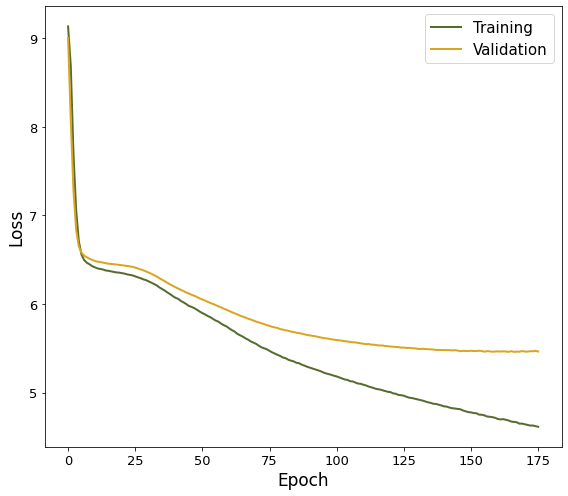

In [114]:
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.plot(tl, label="Training", color="darkolivegreen", linewidth=2)
ax.plot(vl, label="Validation", color="goldenrod", linewidth=2)
ax.set_ylabel("Loss", fontsize=17)
ax.set_xlabel("Epoch", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig(path+"final_training-final.png")
plt.show()

In [121]:
net = torch.load(path+"Final_model.torch", map_location=torch.device('cuda'))
net.predict("Thou art not ", 30)

Found letters: [' ', 'a', 'h', 'n', 'o', 'r', 't', 'u']
Thou art not pity , and such resort to wine my mistress as the love s and power , which there roses doth our axe and tellus on the time is far to 

In [136]:
net.predict("Tomorrow and Tomorrow ", 30)

Found letters: [' ', 'a', 'd', 'm', 'n', 'o', 'r', 't', 'w']
Tomorrow and Tomorrow . is a judgement to hypertext spirits . kinds shortly . enter . dwell free of piteous meet . sweets . it queene to glass troubled of the little inuisible 

In [134]:
net.predict("Shall I compare thee to a summer's day ", 30)

Found letters: [' ', 'a', 'c', 'd', 'e', 'h', 'i', 'l', 'm', 'o', 'p', 'r', 's', 't', 'u', 'y']
Shall I compare thee to a summer's day is in which watery than with exchanges and form of thy bear , giue my dwell pace , that was with a let a false sweet eyes drudge , thy 